## MNIST digit classifier with a neural-ODE
This version is a mashup of the original from Chen's neural-ode site and from Surtsukiv's githup site.  
The difference is that Surtsukov derives the entire adjoint solution and here we just take odeint from torchedifeq.  

In [2]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

In [3]:
tol=1e-3
from torchdiffeq import odeint_adjoint as odeint

In [22]:
class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=tol, atol=tol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


In [24]:
def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)


In [45]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


In [46]:
class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)


In [47]:
class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.relu(self.norm1(x))
        out = self.conv1(t, out)
        out = self.relu(self.norm2(out))
        out = self.conv2(t, out)
        dxdt = self.norm3(out)
        return dxdt


In [49]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [92]:
dxdt = ODEfunc(64)
ode = ODEBlock(dxdt)
model = ContinuousNeuralMNISTClassifier(ode)


In [93]:
dxdt

ODEfunc(
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv1): ConcatConv2d(
    (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConcatConv2d(
    (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [91]:
ode

ODEBlock(
  (odefunc): ODEfunc(
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): ConcatConv2d(
      (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): ConcatConv2d(
      (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [77]:
model

ContinuousNeuralMNISTClassifier(
  (downsampling): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (feature): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [78]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

In [79]:
optimizer = torch.optim.Adam(model.parameters())

In [80]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [81]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [82]:
n_epochs = 1
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...



Test Accuracy: 10.280%
Training Epoch 1...



Train loss: 0.14809
Testing...



Test Accuracy: 98.620%


In [83]:
dataset = test_loader.dataset
n_samples = len(dataset)

# to get a random sample
random_index = int(np.random.random()*n_samples)
single_example = dataset[random_index]

In [84]:
single_example[0].shape

torch.Size([1, 28, 28])

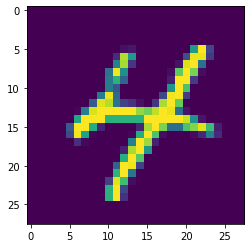

In [85]:
plt.imshow(single_example[0][0].numpy())

In [86]:
x = single_example[0].reshape(1,1,28,28)
print(model(x))

tensor([[-5.2451,  3.1973, -2.1486, -1.5591, 10.4601, -1.5448, -2.6840,  4.2738,
         -0.2286, -1.8871]], grad_fn=<AddmmBackward>)


In [87]:
data_list = []
target_list = []
for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
    data_list.append(data)
    target_list.append(target)

In [88]:
data_list[0].shape

torch.Size([128, 1, 28, 28])

tensor(8) tensor(8)


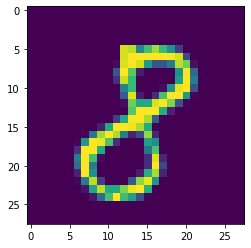

tensor(4) tensor(4)


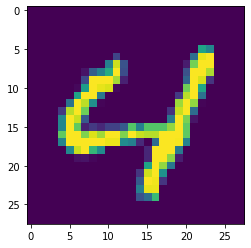

tensor(6) tensor(6)


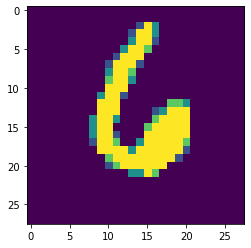

tensor(1) tensor(1)


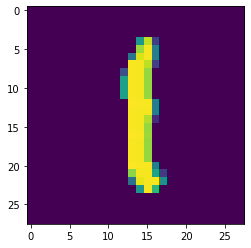

tensor(3) tensor(3)


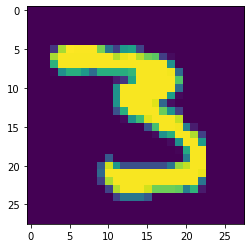

In [89]:
model.eval()
with torch.no_grad():
    v =model(data_list[0])
    for i in range(5):
        print(np.argmax(v[i]), target_list[0][i])
        plt.imshow(data_list[0][i][0].numpy())
        plt.show()